# Data_Gathering

In [1]:
!pip install psycopg2-binary

In [2]:
!pip install nltk

In [3]:
import pandas as pd
import numpy as np
import psycopg2 as pg2
from psycopg2.extras import RealDictCursor, Json
import requests
import time
import seaborn as sns
sns.set()
import nltk
nltk.download('wordnet')

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
import re
from nltk.tokenize import RegexpTokenizer

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from sklearn.feature_extraction.text import CountVectorizer

For computation efficiency, I used PostgresSQL on the server-side to store my data for easier querying and manipulation of data.

I created the tables with the appropriate data types for each columns to store values from the csv files:
```
CREATE TABLE ratings(
  user_id INT,
  movie_id INT,
  rating NUMERIC,
  timestamp_ TIMESTAMP
);

CREATE TABLE movie(
  movie_id INT,
  title TEXT,
  genres TEXT
);

CREATE TABLE link(
  movie_id INT,
  imdb_id NUMERIC,
  tmdb_id NUMERIC
);

CREATE TABLE tag(
  user_id INT,
  movie_id INT,
  tag TEXT,
  timestamp_ TIMESTAMP
);
```



I copied the four csv files that contained my data into the established tables from above:

```
COPY ratings FROM '/rating.csv' WITH DELIMITER ',' HEADER CSV;
COPY movie FROM '/movie.csv' WITH DELIMITER ',' HEADER CSV;
COPY link FROM '/link.csv' WITH DELIMITER ',' HEADER CSV;
COPY tag FROM '/tag.csv' WITH DELIMITER ',' HEADER CSV;
```

I access my database with the IP address and database name outlined in the `sql.py` script

In [5]:
%run '../sql.py'

In [6]:
def con_cur_to_db(dbname=DBNAME):
    ''' 
    Returns both a connection and a cursor object for your database
    '''
    con = pg2.connect(host=IP_ADDRESS,
                  dbname=dbname,
                  user=USER,
                  password=PASSWORD)
    cur = con.cursor()
    return con, cur

def con_cur_to_db_dict(dbname=DBNAME):
    con = pg2.connect(host=IP_ADDRESS,
                  dbname=dbname,
                  user=USER,
                  password=PASSWORD)
    cur = con.cursor(cursor_factory=RealDictCursor)
    return con, cur
    
def execute_query(query, dbname=DBNAME):
    '''
    Executes a query directly to a database, without having to create a cursor and connection each time. 
    '''
    con, cur = con_cur_to_db(dbname)
    cur.execute(f'{query}')
    data = cur.fetchall()
    con.close()
    return data
    
def execute_query_dict(query, dbname=DBNAME):
    con, cur = con_cur_to_db_dict(dbname)
    cur.execute(f'{query}')
    data = cur.fetchall()
    con.close()
    return data

I grab all the columns from the movie table and save into movies dataframe

In [7]:
query = '''SELECT * FROM movie;'''

response = execute_query(query)

movies = pd.DataFrame(response)

movies.columns = ['movie_id', 'title', 'genres']

movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


I grab ratings for movies that have more than 9 number of reviews by users

In [8]:
query = '''
SELECT a.movie_id, a.user_id, a.rating
FROM ratings a
INNER JOIN 
    (SELECT movie_id
    FROM ratings
    GROUP BY movie_id
    HAVING COUNT(*) > 9) b
ON a.movie_id = b.movie_id;'''

response = execute_query(query)

ratings_filtered = pd.DataFrame(response)

ratings_filtered.columns = ['movie_id', 'user_id', 'rating']

ratings_filtered.head()

,movie_id,user_id,rating
0,79293,52263,4
1,79590,52263,3.5
2,79702,52263,4
3,80463,52263,4
4,80831,52263,3


In [9]:
print(f"There are {ratings_filtered['movie_id'].nunique()} unique number of movies")
print(f"There are {ratings_filtered['user_id'].nunique()} unique number of users")
print(f"There are {ratings_filtered['rating'].count()} reviews given by users on movies")

There are 15451 unique number of movies
There are 138493 unique number of users
There are 19964833 reviews given by users on movies


## Exploratory Data Analysis

Text(0.5,1,'Distribution of ratings')

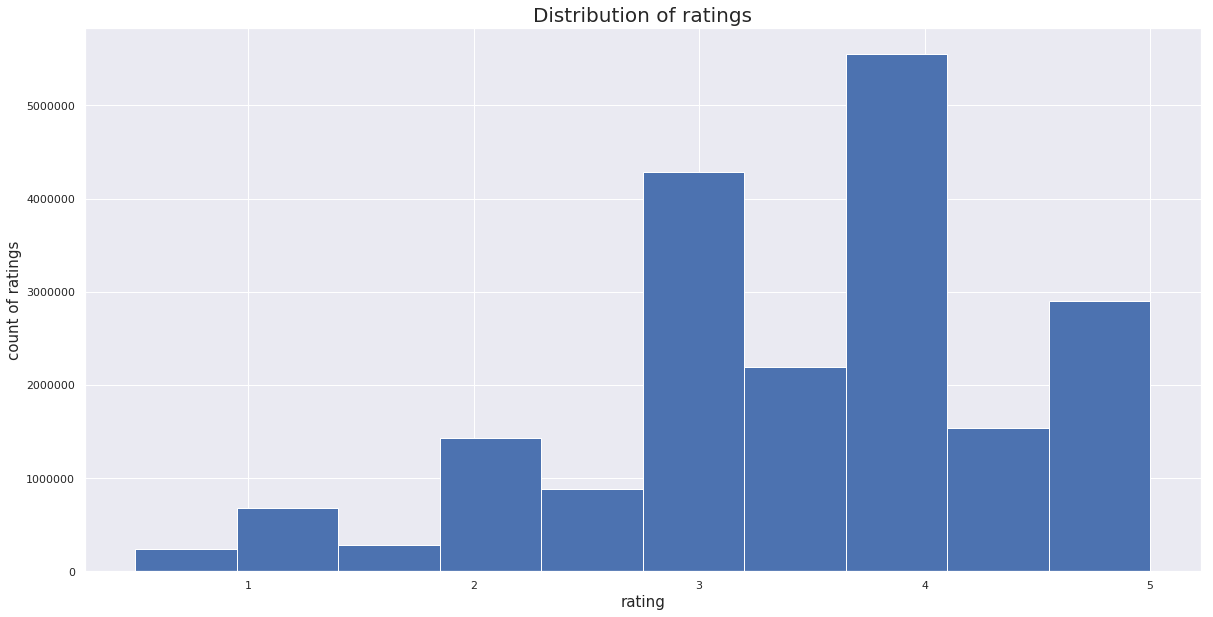

In [10]:
ratings_filtered['rating'] = ratings_filtered['rating'].astype(float)
ratings_filtered.hist('rating', figsize = (20,10), bins = 10)
plt.xlabel('rating', fontsize = 15)
plt.ylabel('count of ratings', fontsize = 15)
plt.title('Distribution of ratings', fontsize = 20)

There are many movies that are given ratings from 3 to 5. It is evident that many people are quite generous with their reviews.

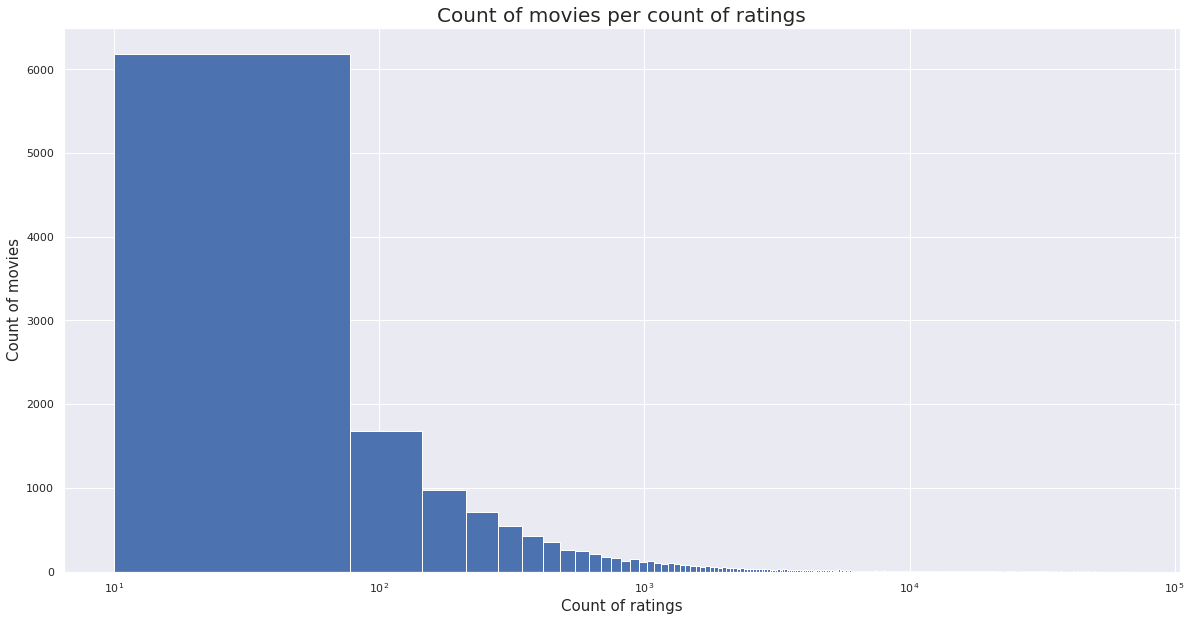

In [11]:
ratings_filtered_count = pd.DataFrame(ratings_filtered.groupby('movie_id').count()['rating'])
ratings_filtered_count.hist('rating', figsize = (20,10), bins = 1000)
plt.xlabel('Count of ratings', fontsize = 15)
plt.ylabel('Count of movies', fontsize = 15)
plt.title('Count of movies per count of ratings', fontsize = 20)
plt.xscale('log')

We currently have about 6000 movies with approximately 10 ratings and approximately 1500 movies with 100-ish ratings and so forth.

In [12]:
movies = pd.concat([movies, movies['genres'].str.get_dummies(sep='|')], axis=1)

In [13]:
movies.head()

,movie_id,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
movies.columns

Index(['movie_id', 'title', 'genres', '(no genres listed)', 'Action',
       'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [15]:
genres = ['Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western']

**_How to sort in ascending order_**

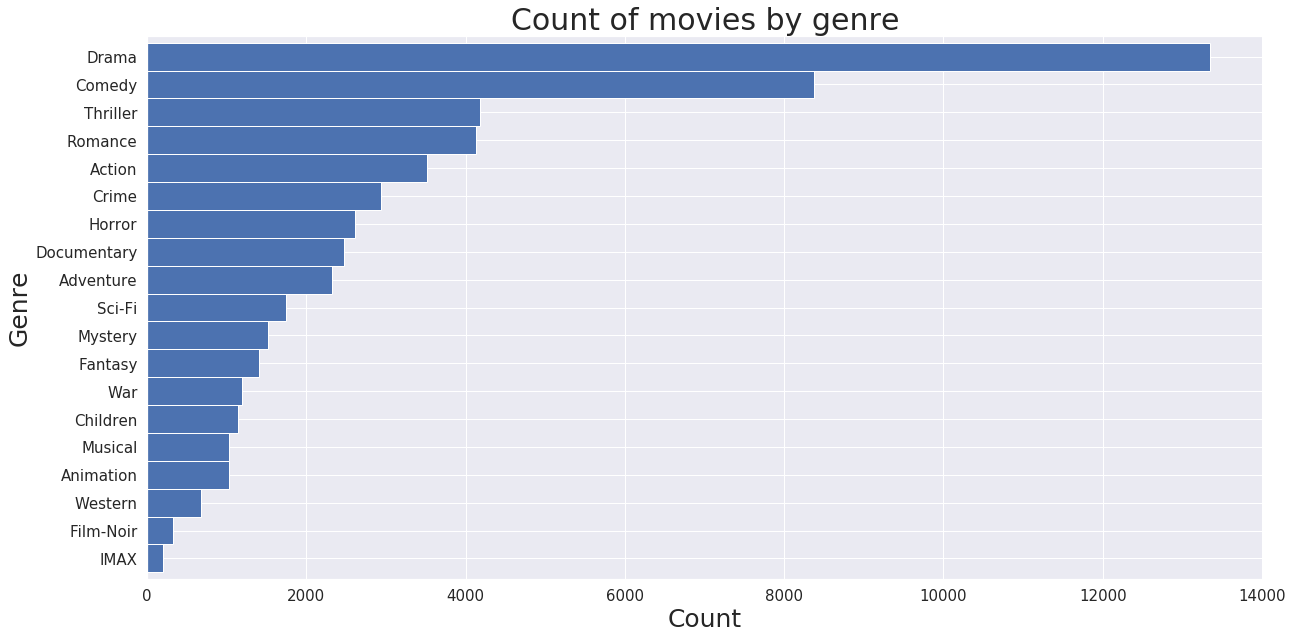

In [16]:
fig = plt.figure(figsize=(20,10))
movies[genres].sum().sort_values().plot(kind='barh', color = 'b', width = 1)
plt.title('Count of movies by genre', size = 30)
plt.xlabel('Count', size = 25)
plt.ylabel('Genre', size = 25)
plt.xticks(size = 15)
plt.yticks(size = 15);

Movies that belong to the drama genre exist the most in our database followed by comedy and thriller. From this graph, I can expect many movies recommended to be drama related.

(0.0, 18.0)

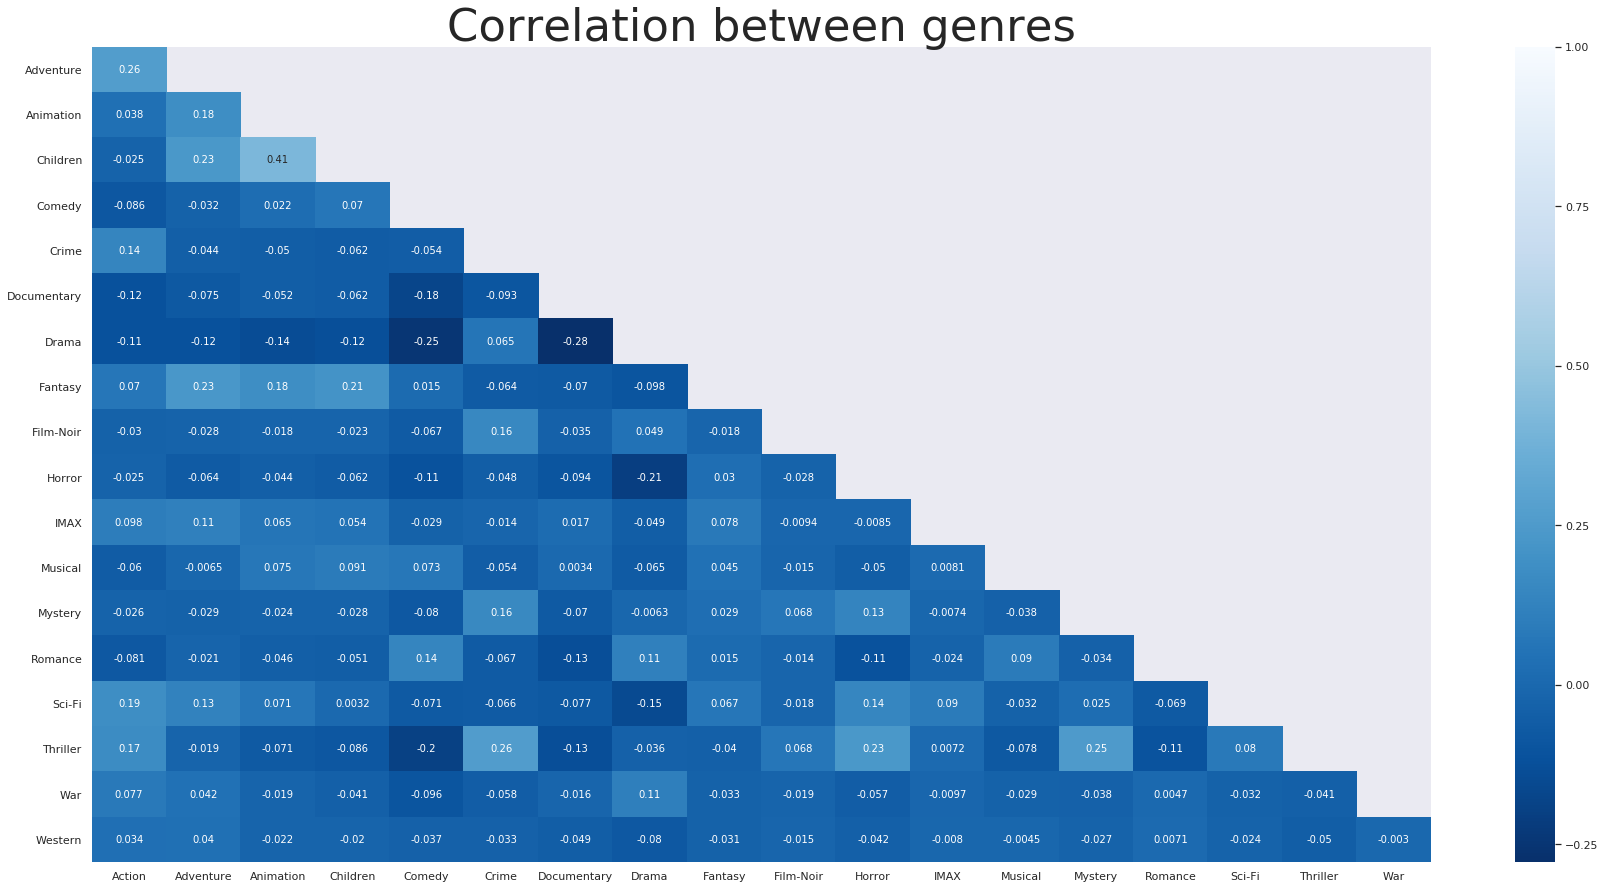

In [17]:
fig = plt.figure(figsize = (30,15))
mask = np.triu(np.ones_like(movies[genres].corr()))
ax = sns.heatmap(
    movies[genres].corr(), annot = True,
    mask = mask,
    cmap = 'Blues_r')
ax.set_title('Correlation between genres', fontsize = 45)
y_min, y_max = ax.get_ylim() ##getting rid of the variable with corr 1
x_min, x_max = ax.get_xlim()
ax.set_ylim(top=y_max+1)
ax.set_xlim(right=x_max-1)

The above plot displays the cooccurence of genres within our count of genres. For example, there is a low correlation between Drama and Comedy (-0.25) and a relatively high correlation factor of Thriller and Crime (0.26). This can be interpreted as we have many movies that are both thriller and crimes but not many movies that are Drama and Comedy. 

Text(0.5,1,'Number of movies per average rating')

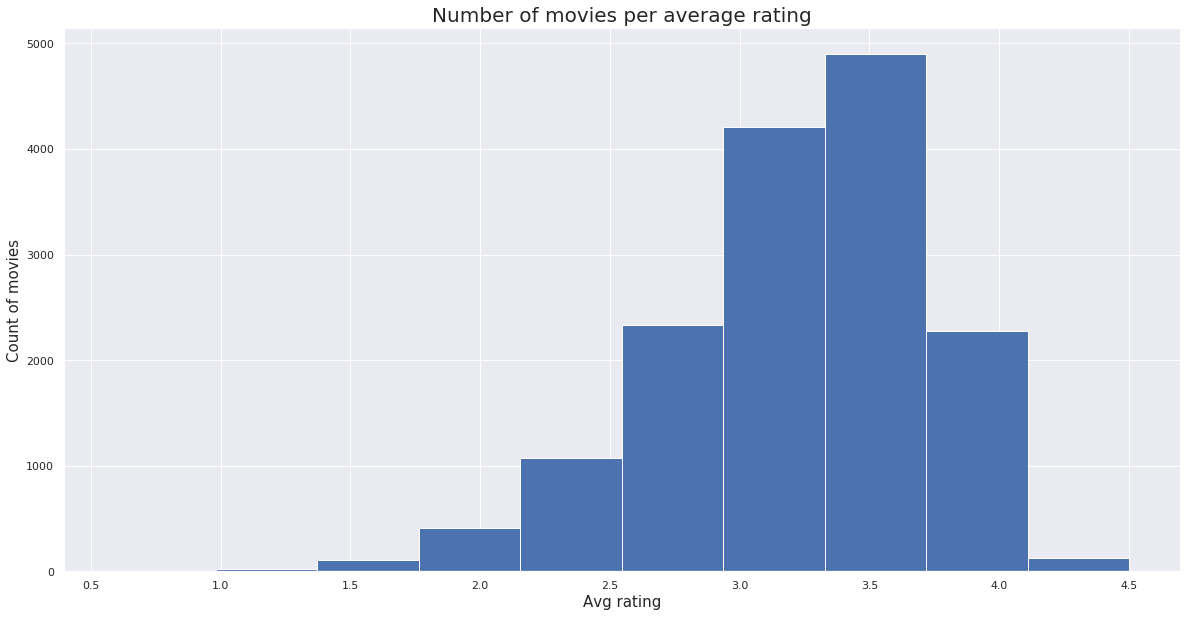

In [18]:
mean_ratings = pd.DataFrame(ratings_filtered.groupby('movie_id').mean()['rating'])

mean_ratings['rating'] = mean_ratings['rating'].astype(float)

mean_ratings.hist('rating', figsize = (20,10), bins = 10)
plt.xlabel('Avg rating', fontsize = 15)
plt.ylabel('Count of movies', fontsize = 15)
plt.title('Number of movies per average rating', fontsize = 20)

We have an average movie rating of 3.0 ~ 3.5 for most of our movies which is to be expected as ratings are averaged across the 1 to 5 number line.

## TMDB

### Using TMDB API

I queried the TMDB API to retrieve information about a movie's overview if the tmdb_id existed from the link table directly into the PostgreSQL database.

In [19]:
query = '''SELECT * FROM link;'''

response = execute_query(query)

link = pd.DataFrame(response)

link.columns = ['movie_id', 'imdb_id', 'tmdb_id']

link.head()

,movie_id,imdb_id,tmdb_id
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862


I queried the TMDB API using the wrapper 

In [20]:
def movie_content(tmdbId):
    url = 'https://api.themoviedb.org/3/movie/{}?api_key=e1527038a510ed4e34865cd1817c0c73&language=en-US'.format(tmdbId)   
    response = requests.get(url)
    if response.status_code == 200:
        resp_json = response.json()
    else:
        print(response.status_code)
    time.sleep(.26)
    return response.json()

In [21]:
# all_movie = []
# for i in link['tmdb_id']:
#     data = movie_content(str(i))
#     all_movie.append(data)

In [22]:
query = '''SELECT * FROM movie;'''

response = execute_query(query)

movies = pd.DataFrame(response)

movies.columns = ['movie_id', 'title', 'genres']

movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [23]:
movies.shape

(27278, 3)

In [24]:
query = '''SELECT * FROM link;'''

response = execute_query(query)

link = pd.DataFrame(response)

link.columns = ['movie_id', 'imdb_id', 'tmdb_id']

link.head()

,movie_id,imdb_id,tmdb_id
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862


In [25]:
link['movie_id'].nunique()

27243

In [26]:
link['tmdb_id'].nunique()

26991

There were approximately 250 tmdb_ids that were missing from the link table that will be dropped when using tmdb's API

In [27]:
query = '''SELECT movie_id, id, title, release_date, overview FROM movie_info_updated;'''

response = execute_query(query)

movie_info_updated = pd.DataFrame(response)

movie_info_updated.columns = ['movie_id', 'tmdb_id', 'title', 
                      'release_date', 'overview']

movie_info_updated.head()

,movie_id,tmdb_id,title,release_date,overview
0,1,862,Toy Story,1995-10-30,"Led by Woody, Andy's toys live happily in his ..."
1,2,8844,Jumanji,1995-12-15,When siblings Judy and Peter discover an encha...
2,3,15602,Grumpier Old Men,1995-12-22,A family wedding reignites the ancient feud be...
3,129,110972,Pie in the Sky,1996-02-09,Pie in the Sky is a 1996 American romantic com...
4,654,278978,Und keiner weint mir nach,1996-02-29,


In [28]:
movie_info_updated.shape

(26742, 5)

In [29]:
movie_info_updated.movie_id.nunique()

26742

In addition, movies that had duplicate ids when they were queried from the tmdb database were eliminated, explaining the further discrpenacy in the number of movies from movies.csv (from MovieLens) and the number of movies from movie_info_updated.

In [30]:
merged = pd.merge(movie_info_updated, movies, on = 'movie_id')

In [31]:
merged.head()

,movie_id,tmdb_id,title_x,release_date,overview,title_y,genres
0,1,862,Toy Story,1995-10-30,"Led by Woody, Andy's toys live happily in his ...",Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,8844,Jumanji,1995-12-15,When siblings Judy and Peter discover an encha...,Jumanji (1995),Adventure|Children|Fantasy
2,3,15602,Grumpier Old Men,1995-12-22,A family wedding reignites the ancient feud be...,Grumpier Old Men (1995),Comedy|Romance
3,129,110972,Pie in the Sky,1996-02-09,Pie in the Sky is a 1996 American romantic com...,Pie in the Sky (1996),Comedy|Romance
4,654,278978,Und keiner weint mir nach,1996-02-29,,And Nobody Weeps for Me (Und keiner weint mir ...,Drama|Romance


In [32]:
merged.drop('title_x', axis = 1, inplace = True)

In [33]:
merged.isnull().sum()

movie_id        0
tmdb_id         0
release_date    0
overview        0
title_y         0
genres          0
dtype: int64

In [34]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26742 entries, 0 to 26741
Data columns (total 6 columns):
movie_id        26742 non-null int64
tmdb_id         26742 non-null object
release_date    26742 non-null object
overview        26742 non-null object
title_y         26742 non-null object
genres          26742 non-null object
dtypes: int64(1), object(5)
memory usage: 1.4+ MB


In [35]:
tokenizer = RegexpTokenizer(r'\w+')

In [38]:
merged['overview_tokenized'] = merged['overview'].map(lambda x: tokenizer.tokenize(x))

In [39]:
merged.head()

,movie_id,tmdb_id,release_date,overview,title_y,genres,overview_tokenized
0,1,862,1995-10-30,"Led by Woody, Andy's toys live happily in his ...",Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Led, by, Woody, Andy, s, toys, live, happily,..."
1,2,8844,1995-12-15,When siblings Judy and Peter discover an encha...,Jumanji (1995),Adventure|Children|Fantasy,"[When, siblings, Judy, and, Peter, discover, a..."
2,3,15602,1995-12-22,A family wedding reignites the ancient feud be...,Grumpier Old Men (1995),Comedy|Romance,"[A, family, wedding, reignites, the, ancient, ..."
3,129,110972,1996-02-09,Pie in the Sky is a 1996 American romantic com...,Pie in the Sky (1996),Comedy|Romance,"[Pie, in, the, Sky, is, a, 1996, American, rom..."
4,654,278978,1996-02-29,,And Nobody Weeps for Me (Und keiner weint mir ...,Drama|Romance,[]


In [40]:
merged['overview_features'] = merged['overview_tokenized'].map(lambda x: ' '. join([lemmatizer.lemmatize(word) for word in x]))


In [41]:
cv = CountVectorizer(ngram_range=(1,1), 
                             stop_words = 'english', 
                             min_df = 5, 
                             max_df = 1.0)

min_df will remember words that are in a document at least once. For example,
if min_df = 5, will only remember words that are a part of 5 documents in a corpus. max_df refers to the %-age of documents within a corpus that a word occurs in. For example, if max_df = 0.9, words that occur in more than 90% of my documents will be ignored. By default, max_df is equal to 1.

In [42]:
term_mat = cv.fit_transform(merged['overview_features'])

In [43]:
term_df = pd.DataFrame(term_mat.toarray(), columns=cv.get_feature_names())

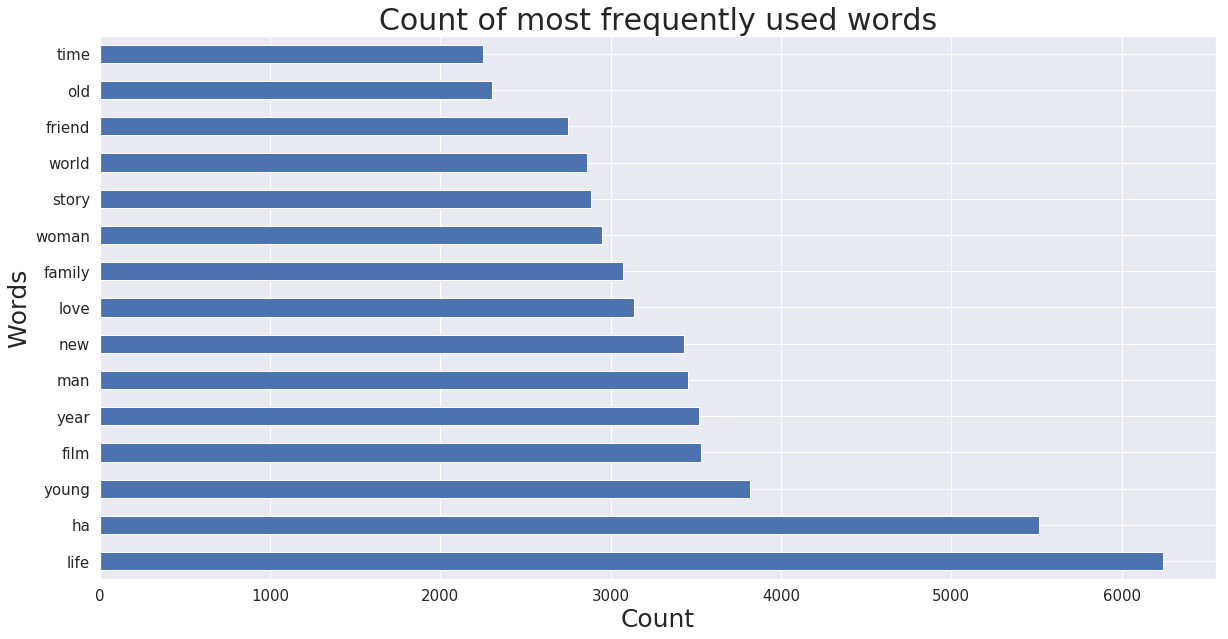

In [44]:
fig = plt.figure(figsize=(20,10))
term_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', color = 'b')
plt.title('Count of most frequently used words', size = 30)
plt.xlabel('Count', size = 25)
plt.ylabel('Words', size = 25)
plt.xticks(size = 15)
plt.yticks(size = 15);

Many overviews include the words such as 'life', 'young', 'film', 'man', 'love', 'woman'. It is important to keep in mind that when generating vectors of movies based on its overview, if the overview has similar words, they may be considered similar in a n-dimensional space that we cannot visualize. 

Save out merged as a csv for **02_Preprocessing.ipynb**

In [46]:
merged.to_csv('../assets/merged.csv')